In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

%cd /content

!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything

%cd /content
!git clone https://github.com/xinyu1205/recognize-anything.git
%cd /content/recognize-anything
!pip install -r requirements.txt
!pip install -e .

!pip install cython

%cd /content

/content
fatal: destination path 'Grounded-Segment-Anything' already exists and is not an empty directory.
/content/Grounded-Segment-Anything
/content/Grounded-Segment-Anything/GroundingDINO
  Installing build dependencies ... canceled
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 73, in resolve
    collected = self.factory.collect_root_requirements(root_reqs)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolveli

## Imports

In [ ]:
!pip install PIL

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [ ]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "Grounded-Segment-Anything"))
sys.path.append(os.path.join(os.getcwd(), "Grounded-Segment-Anything", "GroundingDINO"))
sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))
sys.path.append(os.path.join(os.getcwd(), "recognize-anything"))

print(os.getcwd(), os.path.join(os.getcwd(), "Grounded-Segment-Anything", "GroundingDINO"))
print(sys.path)

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# recognise anything
from ram.models import ram
from ram import inference_ram as inference
from ram import get_transform

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
!cd ..
import torch
!cd -
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

/content /content/Grounded-Segment-Anything/GroundingDINO
['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/content/recognize-anything', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/Grounded-Segment-Anything', '/content/Grounded-Segment-Anything/GroundingDINO', '/content/GroundingDINO', '/content/recognize-anything']
/


## Load models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Grounding DINO model

In [ ]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [ ]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


# RAM

In [ ]:
 ! wget https://huggingface.co/spaces/xinyu1205/recognize-anything/resolve/main/ram_swin_large_14m.pth

ram_model = ram(pretrained='ram_swin_large_14m.pth', image_size=384, vit='swin_l')
ram_model.eval()
ram_model.to(device)
1


--2024-01-17 09:28:29--  https://huggingface.co/spaces/xinyu1205/recognize-anything/resolve/main/ram_swin_large_14m.pth
Resolving huggingface.co (huggingface.co)... 18.172.134.4, 18.172.134.124, 18.172.134.24, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/e6/78/e678f8565485a3f321b1180e4c7e1e18a89a9295028358eedffb98981b37e11a/15c729c793af28b9d107c69f85836a1356d76ea830d4714699fb62e55fcc08ed?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27ram_swin_large_14m.pth%3B+filename%3D%22ram_swin_large_14m.pth%22%3B&Expires=1705742909&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNTc0MjkwOX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9lNi83OC9lNjc4Zjg1NjU0ODVhM2YzMjFiMTE4MGU0YzdlMWUxOGE4OWE5Mjk1MDI4MzU4ZWVkZmZiOTg5ODFiMzdlMTFhLzE1YzcyOWM3OTNhZjI4YjlkMTA3YzY5Zjg1ODM2YTEzNTZkNzZlYTgzMG

1

In [ ]:
test_img_path = '/content/drive/MyDrive/da_assets/rgb1.png'
transform = get_transform(image_size=384)
image = transform(Image.open(test_img_path)).unsqueeze(0).to(device)

res = inference(image, ram_model)

Image.open(test_img_path).show()

In [ ]:
res = inference(image, ram_model)
print("Image Tags: ", res[0])

Image Tags:  armchair | carpet | ceiling | chair | couch | curtain | den | table | floor | furniture | glass table | living room | room | slide | window


### SAM

In [ ]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

--2024-01-17 09:30:01--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   175MB/s    in 23s     

2024-01-17 09:30:24 (109 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



## Inference

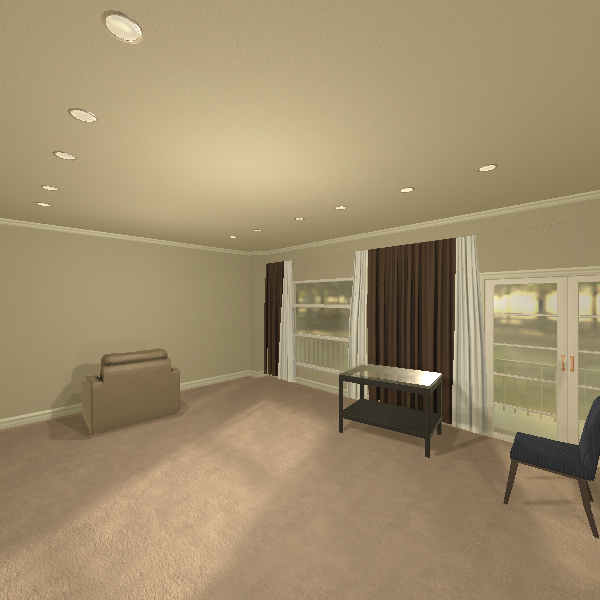

In [ ]:
# Load image
def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)
    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))


local_image_path = "/content/drive/MyDrive/da_assets/rgb1-2.png"
# image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"

# download_image(image_url, local_image_path)
image_source, image = load_image(local_image_path)
Image.fromarray(image_source)

## Grounding DINO for detection

In [ ]:
# detect object using grounding DINO
def detect(image, text_prompt, model, image_source=None, box_threshold = 0.3, text_threshold = 0.25, remove_combined=False):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  if type(image_source) == None:
    annotated_frame = None
  else:
    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    annotated_frame = annotated_frame[...,::-1] # BGR to RGB

  return annotated_frame, boxes

In [ ]:
!pip install sympy
!pip install cython

In [ ]:
annotated_frame, detected_boxes = detect(image, text_prompt="armchair | carpet | ceiling | chair | couch | curtain | den | table | floor | furniture | glass table | living room | room | slide | window",
                                         model=groundingdino_model,
                                         image_source=image_source)
Image.fromarray(annotated_frame)

NameError: name '_C' is not defined

In [ ]:
print(detected_boxes)

In [ ]:
# return a tensor containing all bounding boxes
# filter for duplicates by calculating

# [TODO] speedup

import time

def getIoU(rect1, rect2):
  area_rect1 = rect1[2]*rect1[3]
  area_rect2 = rect2[2]*rect2[3]

  overlap_top_left = (max(rect1[0], rect2[0]), max(rect1[1], rect2[1]))
  overlap_bottom_right = (min(rect1[0] + rect1[2], rect2[0] + rect2[2]), min(rect1[1] + rect1[3], rect2[1] + rect2[3]))

  if (overlap_bottom_right[0] <= overlap_top_left[0]) or (overlap_bottom_right[1] <= overlap_top_left[1]):
    return 0.0  # No overlap, return 0% overlap

  # Calculate the area of the overlap rectangle
  overlap_area = abs((overlap_bottom_right[0] - overlap_top_left[0]) * (overlap_bottom_right[1] - overlap_top_left[1]))
  percent_overlap = (overlap_area / min(area_rect1, area_rect2))

  return percent_overlap

def compSize(rect1, rect2):
  area_rect1 = rect1[2]*rect1[3]
  area_rect2 = rect2[2]*rect2[3]

  diff = min(area_rect1, area_rect2)/max(area_rect1, area_rect2)
  return diff


def getAllDetectedBoxes(image, image_source=None, keywords=[], show=False, intersection_threshold=0.7, size_threshold=0.75):
  total_time = 0

  with torch.no_grad():
    boxes = []
    unique_boxes_num = 0

    for i, word in enumerate(keywords):
      af, detected = detect(image, image_source=image_source, text_prompt=str(word), model=groundingdino_model)

      cnt_time = time.time()

      # # limit edges
      # for d in detected:
      #   if d[0] + d[2] >= 1:
      #     d[2] = 1 - d[0]

      #   if d[1] + d[3] >= 1:
      #     d[3] = 1 - d[1]

      if show:
        print(i)
      unique_enough = True

      if detected != None and len(detected) != 0:
        if unique_boxes_num == 0:
          for box in detected:
            boxes.append(box)
            unique_boxes_num += 1

          if show and type(image_source) != None:
            Image.fromarray(af).show()

            if show:
              print("detected", detected)

        else:
          print("boxes: ", boxes)
          for box in detected:
            unique_enough = True

            if show:
              print("detected: ", detected)

            for prev in boxes[:unique_boxes_num]:

              iou = getIoU(box, prev)
              diff = compSize(box, prev)

              if show:
                print("comparing; -- ", prev, box)
                print("iou: ", iou)
                print("diff: ", diff)

              if (iou > intersection_threshold and diff > size_threshold):
                # bounding box is not unique enough to be added
                unique_enough = False

                if show:
                  print("failed")
                break

            if unique_enough:
              boxes.append(box)
              unique_boxes_num += 1

              if show:
                print("         success!")
                print(boxes)

          if show and type(image_source) != None:
            Image.fromarray(af).show()

      total_time += (time.time() - cnt_time)

    print(total_time)
    return torch.stack(boxes)

In [ ]:
def decide_uniqueness(candidate_boxes, stored_boxes, intersection_threshold=0.7, size_threshold=0.75):
  # get area difference
  candidate_areas = 4 * candidate_boxes[:,2] * candidate_boxes[:,3]
  stored_areas = 4 * stored_boxes[:,2] * stored_boxes[:,3]
  minimum_areas = np.minimum(candidate_areas.unsqueeze(1), stored_areas)

  area_diff = candidate_areas.unsqueeze(1)/stored_areas
  area_diff[area_diff >= 1.] = 1/area_diff[area_diff >= 1.]

  conv_cb = candidate_boxes.clone()
  conv_sb = stored_boxes.clone()

  conv_cb[:, :2] -= conv_cb[:, 2:]
  conv_cb[:, 2:] = 2 * conv_cb[:, 2:] + conv_cb[:, :2]
  conv_cb = np.expand_dims(conv_cb, axis=1)

  conv_sb[:, :2] -= conv_sb[:, 2:]
  conv_sb[:, 2:] = 2 * conv_sb[:, 2:] + conv_sb[:, :2]

  overlap_boxes = np.concatenate([np.maximum(conv_cb[...,:2], conv_sb[...,:2]),
                                  np.minimum(conv_cb[...,2:], conv_sb[...,2:])],
                                 axis=-1)

  iou = np.where(np.logical_and((overlap_boxes[..., 2] > overlap_boxes[..., 0]), (overlap_boxes[..., 3] > overlap_boxes[..., 1])),
                 (overlap_boxes[..., 3] - overlap_boxes[..., 1]) * (overlap_boxes[..., 2] - overlap_boxes[..., 0])/minimum_areas,
                 -np.inf)

  boxes_comparison = np.where(
      np.logical_and(np.logical_and(iou > intersection_threshold, area_diff > size_threshold), iou != -np.inf),
      False,
      True
  )

  unique_enough = np.logical_and.reduce(boxes_comparison, 1)

  return unique_enough


def eff_getAllDetectedBoxes(image, image_source=None, keywords=[], show=False, intersection_threshold=0.7, size_threshold=0.75):
  with torch.no_grad():
    boxes = None
    unique_boxes_num = 0

    total_time = 0

    for i, word in enumerate(keywords):
      af, detected = detect(image, image_source=image_source, text_prompt=str(word), model=groundingdino_model)

      cnt_time = time.time()

      if show:
        print(i)
      # unique_enough = True

      # sort through all detected boxes, add them if there is little enough overlap with all recorded bboxes, or it is small enough for overlap to not matter
      if detected != None and len(detected) != 0:
        if boxes == None:
          boxes = detected

          if show and type(image_source) != None:
            Image.fromarray(af).show()

            if show:
              print("detected", detected)

        else:
          if show:
            print("boxes:\n", boxes)

            if type(image_source) != None:
              Image.fromarray(af).show()


          unique_enough = decide_uniqueness(detected, boxes)
          boxes = torch.concat([boxes] + [detected[num].unsqueeze(0) for num, val in enumerate(unique_enough) if val])

          if show:
            for i, k in enumerate(unique_enough):
              print("Added " if k else "Failed ", sep='')
              print(detected[i])


          total_time += (time.time() - cnt_time)

    print(total_time)
    return boxes

In [ ]:
a = torch.tensor(np.array([[[2.,2.,2.,2.]], [[11.,1.,6.,8.]]]))
b = torch.tensor(np.array([[3.,3.,2.,2.], [5.,6.,7.,8.], [9.,11.,12.,13.]]))
conv_cb = torch.tensor(np.array([[2.,2.,2.,2.], [2.,2.,1.,1.], [9.5, 9.5, 2., 2.]]))
conv_sb = torch.tensor(np.array([[3.,3.,2.,2.], [10.,10.,2.,2.]]))

print(conv_cb,'\n', conv_sb)
i = decide_uniqueness(conv_cb, conv_sb, 0.5)
print(i)

print([conv_cb[num] for num, val in enumerate(i) if val])

In [ ]:
getAllDetectedBoxes(image, image_source, [l for l in "armchair | carpet | ceiling | chair | couch | curtain | den | table | floor | furniture | glass table | living room | room | slide | window".split("|")],
                                     show=False)

In [ ]:
eff_getAllDetectedBoxes(image, image_source, [l for l in "armchair | carpet | ceiling | chair | couch | curtain | den | table | floor | furniture | glass table | living room | room | slide | window".split("|")],
                                     show=False)

In [ ]:
image2_source, image2 = load_image("/content/drive/MyDrive/da_assets/rgb1.png")

detected_boxes = getAllDetectedBoxes(image, image_source, [l for l in "armchair | carpet | ceiling | chair | couch | curtain | den | table | floor | furniture | glass table | living room | room | slide | window".split("|")],
                                     show=True)
detected_boxes

## SAM for segmentation

In [ ]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return boxes_xyxy, masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [ ]:
bboxs, segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)

print(bboxs)
print()
print(segmented_frame_masks[0])

In [ ]:
for idx in range(segmented_frame_masks.shape[0]):
  annotated_frame_with_mask = draw_mask(segmented_frame_masks[idx][0], annotated_frame)
  Image.fromarray(annotated_frame_with_mask).show()


# Mask test

In [ ]:
mask_test = np.copy(image_source)

mask_test[segmented_frame_masks[7][0] == False] = 0

bounds = [502, 394, 600, 538]
Image.fromarray(mask_test).show()


In [ ]:
bboxs = bboxs.numpy().astype(int)

In [ ]:
bboxs

In [ ]:
for idx in [0,1,2]:
  Image.fromarray(image_source[bboxs[idx][1]:bboxs[idx][3], bboxs[idx][0]:bboxs[idx][2]]).show()

In [ ]:
# cv2.imwrite('chair_1_2.png', image_source[bboxs[idx][1]:bboxs[idx][3], bboxs[idx][0]:bboxs[idx][2]]getAllDetectedBoxes(image, [l for l in "armchair | carpet | ceiling | chair | couch | curtain | den | table | floor | furniture | glass table | living room | room | slide | window".split("|")],
#                                      True)

# Get images, remove dupes

In [ ]:
# supply an image and all keywords, returns bounding box cropped
def getAllSegmentedImages(image_path, keywords, show=False):
  image_source, image = load_image(image_path)
  cropped_images = []

  detected_boxes = getAllDetectedBoxes(image, keywords=keywords, show=True)
  bboxs, segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)

  bboxs = bboxs.numpy().astype(int)
  for idx in range(detected_boxes.shape[0]):
    cropped_images.append(image_source[bboxs[idx][1]:bboxs[idx][3], bboxs[idx][0]:bboxs[idx][2]])

    Image.fromarray(image_source[bboxs[idx][1]:bboxs[idx][3], bboxs[idx][0]:bboxs[idx][2]]).show()

  return cropped_images

# supply an image and all keywords, returns bounding box cropped
def objectDetectionPipeline(image_path, show=False):
  # get keywords
  ram_transform = get_transform(image_size=384)
  ram_image = ram_transform(Image.open(image_path)).unsqueeze(0).to(device)

  res = inference(ram_image, ram_model)
  keywords = res[0].split(' | ')

  print(keywords)

  keywords = [i for i in keywords if (i != 'curtains') and (i != 'curtain')]

  # load images for dyno and sam
  image_source, image = load_image(image_path)
  cropped_images = []

  detected_boxes = getAllDetectedBoxes(image, image_source=image_source, keywords=keywords, show=show)
  bboxs, segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)

  if len(bboxs) != len(detected_boxes):
    print("\n\n\n\nMISSING STUFF\nKHDSFKJHDSKFJLHDSKLJFHKLSDFH\nKHDSFKJHDSKFJLHDSKLJFHKLSDFH\n\n\n\n")

  H, W = image_source.shape[:2]
  detected_boxes = detected_boxes * torch.Tensor([W, H, W, H])
  # from xywh to xyxy
  detected_boxes[:, :2] -= detected_boxes[:, 2:] / 2
  detected_boxes[:, 2:] += detected_boxes[:, :2]

  detected_boxes = detected_boxes.numpy().astype(int)

  # print(bboxs)
  # print(detected_boxes)

  bboxs = bboxs.numpy().astype(int)
  for idx in range(detected_boxes.shape[0]):
    cropped_images.append(image_source[bboxs[idx][1]:bboxs[idx][3], bboxs[idx][0]:bboxs[idx][2]])

    # Image.fromarray(image_source[bboxs[idx][1]:bboxs[idx][3], bboxs[idx][0]:bboxs[idx][2]]).show()
    # Image.fromarray(image_source[detected_boxes[idx][1]:detected_boxes[idx][3], detected_boxes[idx][0]:detected_boxes[idx][2]]).show()
    # print()
    # print()

  return cropped_images, bboxs

In [ ]:
# img1_cropped_images, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/cup.jpeg", True)

# # ram_model.class_threshold = torch.full(og_class_threshold.shape, 0.45)

# with torch.no_grad():
#   ram_transform = get_transform(image_size=384)
#   ram_image = ram_transform(Image.open("/content/drive/MyDrive/da_assets/cup.jpeg")).unsqueeze(0).to(device)

#   tags, tags_chinese = ram_model.generate_tag(ram_image)

#   print(tags[0])



In [ ]:
for i, word in enumerate(ram_model.tag_list):
  if word == 'blue':
    print(i)
    break
# ^ should be 1012 for coffee cup

for i, word in zip(ram_model.class_threshold[1012:1014], ram_model.tag_list[1012:1014]):
  print(i, " | ", word)


# this line stops this object from being considered (apparently)
# can make a custom config to only tag movable objects
# check ram model initialisation and ram_tag_list in recognize-anything/ram/data/ram_tag_list
ram_model.class_threshold[480] = 0.999999999
ram_model.class_threshold[1011:1013] = 0.999999999

In [ ]:
img1_cropped_images, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/rgb1.png", True)

In [ ]:
img2_cropped_images, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/rgb1-2.png", True)

In [ ]:
# for img1, img2 in zip(img1_cropped_images, img2_cropped_images):
#   Image.fromarray(img1).show()
#   Image.fromarray(img2).show()
#   print()


# display retrieved images
fig1, axs1 = plt.subplots(1, len(img1_cropped_images), figsize=(2*len(img1_cropped_images), 2))
for i, img in enumerate(img1_cropped_images):
  axs1[i].imshow(img)
  print(bboxes1[i])
plt.subplots_adjust(wspace=0.4)
plt.show()

fig2, axs2 = plt.subplots(1, len(img2_cropped_images), figsize=(2*len(img2_cropped_images), 2))
for i, img in enumerate(img2_cropped_images):
  axs2[i].imshow(img)
plt.subplots_adjust(wspace=0.4)
plt.show()

# Experiments

In [ ]:
def chooseCroppedImages(img1_cropped, img2_cropped, choice1, choice2, show=True):
  img_array_1 = []
  for i in choice1:
    img_array_1.append(img1_cropped[i])

  img_array_2 = []
  for i in choice2:
    img_array_2.append(img2_cropped[i])

  if show:
    fig1, axs1 = plt.subplots(1, len(img_array_1), figsize=(2*len(img_array_1), 2))
    for i, img in enumerate(img_array_1):
      axs1[i].set_title(str(i))
      axs1[i].imshow(img)
      print(bboxes1[i])
    plt.subplots_adjust(wspace=0.4)
    plt.show()

    fig2, axs2 = plt.subplots(1, len(img_array_2), figsize=(2*len(img_array_2), 2))
    for i, img in enumerate(img_array_2):
      axs2[i].set_title(str(i))
      axs2[i].imshow(img)
    plt.subplots_adjust(wspace=0.4)
    plt.show()

  return img_array_1, img_array_2

In [ ]:
complete_graph_indices_1 = [0,1,4,5,6,8]
complete_graph_indices_2 = [1,0,4,5,6,7]

img_array_1, img_array_2 = chooseCroppedImages(img1_cropped_images, img2_cropped_images, complete_graph_indices_1, complete_graph_indices_2)

In [ ]:
def cosine_similarity(x, y):

    # Ensure length of x and y are the same
    if len(x) != len(y) :
        return None

    # Compute the dot product between x and y
    dot_product = np.dot(x, y)

    # Compute the L2 norms (magnitudes) of x and y
    magnitude_x = np.linalg.norm(x)
    magnitude_y = np.linalg.norm(y)

    # Compute the cosine similarity
    cosine_similarity = dot_product / (magnitude_x * magnitude_y)

    return cosine_similarity

In [ ]:
# Comparing cosine similarity

cosine_similarity_grid = np.zeros((len(img_array_1), len(img_array_2)), np.float)

for i, img1 in enumerate(img_array_1):
  sam_predictor.set_image(img1)
  img1_emb = sam_predictor.features.detach().cpu().numpy().flatten()

  for j, img2 in enumerate(img_array_2):
    sam_predictor.set_image(img2)
    img2_emb = sam_predictor.features.detach().cpu().numpy().flatten()

    cosine_similarity_grid[i,j] = cosine_similarity(img1_emb, img2_emb)

In [ ]:
cosine_only_correspondences = np.argmax(cosine_similarity_grid, axis=1)

print(cosine_similarity_grid)
print("Correspondences: ", cosine_only_correspondences)

In [ ]:
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm

def cosine_similarity(x, y):

    # Ensure length of x and y are the same
    if len(x) != len(y) :
        return None

    # Compute the dot product between x and y
    dot_product = np.dot(x, y)

    # Compute the L2 norms (magnitudes) of x and y
    magnitude_x = np.linalg.norm(x)
    magnitude_y = np.linalg.norm(y)

    # Compute the cosine similarity
    cosine_similarity = dot_product / (magnitude_x * magnitude_y)

    return cosine_similarity

def hungarian_association(img_array_1, img_array_2):
  # Comparing cosine similarity
  cosine_similarity_grid = np.zeros((len(img_array_1), len(img_array_2)), np.float)

  with tqdm(total = len(img_array_1)+len(img_array_1)) as pbar:
    emb1 = []
    emb2 = []

    for i, img1 in enumerate(img_array_1):
      sam_predictor.set_image(img1)
      img1_emb = sam_predictor.features.detach().cpu().numpy().flatten()
      emb1.append(img1_emb)
      pbar.update(1)

    for j, img2 in enumerate(img_array_2):
      sam_predictor.set_image(img2)
      img2_emb = sam_predictor.features.detach().cpu().numpy().flatten()
      emb2.append(img2_emb)
      pbar.update(1)

    # GET COSTS OVER HERE
    for i, e1 in enumerate(emb1):
      for j, e2 in enumerate(emb2):
        cosine_similarity_grid[i,j] = cosine_similarity(e1, e2)

  # get graph
  cost_matrix = 1 - cosine_similarity_grid
  row_idx, col_idx = linear_sum_assignment(cost_matrix)

  print(row_idx, col_idx)
  print("Hungarian algorithm")
  pairs = [i for i in zip(row_idx, col_idx)]

  # similarity heatmap
  plt.imshow(cosine_similarity_grid, cmap='hot', interpolation='nearest')

  plt.colorbar()
  plt.xlabel('Img 2')
  plt.ylabel('Img 1')

  for i in range(cosine_similarity_grid.shape[0]):
    for j in range(cosine_similarity_grid.shape[1]):
      text = f'{cosine_similarity_grid[i, j]:.2f}'  # Format score to two decimal placesg

      if cosine_similarity_grid[i,j] > 0.5:
        text_color = 'black'
      else:
        text_color = 'white'

      if (i, j) in pairs:
        text_color = 'blue'
        text_weight = 'bold'
      else:
        text_weight=None

      plt.text(j, i, text, ha='center', va='center', color=text_color, fontweight=text_weight)

  plt.clim(0, 1);
  plt.show()



In [ ]:
# cosine_similarity_grid = np.array([
#     [0.8, 0.1, 0.1],
#     [0.1, 0.1, 0.1],
#     [0.1, 0.8, 0.1],
#     [0.8, 0.1, 0.1],
# ])

cosine_similarity_grid = np.array([
    [1, 0, 0],
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
])

cost_matrix = 1 - cosine_similarity_grid
row_idx, col_idx = linear_sum_assignment(cost_matrix)


print(row_idx, col_idx)
print("Hungarian algorithm")

pairs = [i for i in zip(row_idx, col_idx)]
print(pairs)

# similarity heatmap
plt.imshow(cosine_similarity_grid, cmap='hot', interpolation='nearest')

plt.colorbar()
plt.xlabel('Img 2')
plt.ylabel('Img 1')

for i in range(cosine_similarity_grid.shape[0]):
  for j in range(cosine_similarity_grid.shape[1]):
    text = f'{cosine_similarity_grid[i, j]:.2f}'  # Format score to two decimal placesg

    if cosine_similarity_grid[i,j] > 0.5:
      text_color = 'black'
    else:
      text_color = 'white'

    print(i, j, " | ", np.argwhere(col_idx == i))
    # if i in row_idx and len(np.argwhere(col_idx == i)) != 0 and np.argwhere(col_idx == i).reshape(-1)[0] == j:
    if (i,j) in pairs:
      text_color = 'blue'
      text_weight = 'bold'
    else:
      text_weight=None

    plt.text(j, i, text, ha='center', va='center', color=text_color, fontweight=text_weight)

plt.clim(0, 1);
plt.show()

In [ ]:
hungarian_association(img_array_1, img_array_2)

In [ ]:
# similarity heatmap only cosine
gt_correspondences = None

plt.imshow(cosine_similarity_grid, cmap='hot', interpolation='nearest')

plt.colorbar()
plt.xlabel('Img 2')
plt.ylabel('Img 1')

for i in range(cosine_similarity_grid.shape[0]):
  for j in range(cosine_similarity_grid.shape[1]):
    text = f'{cosine_similarity_grid[i, j]:.2f}'  # Format score to two decimal places

    if cosine_similarity_grid[i,j] > 0.5:
      text_color = 'black'
    else:
      text_color = 'white'

    if cosine_similarity_grid[i, j] == np.max(cosine_similarity_grid[i]):
      text_color = 'blue'
      text_weight = 'bold'
    else:
      text_weight=None

    plt.text(j, i, text, ha='center', va='center', color=text_color, fontweight=text_weight)

plt.clim(0, 1);
plt.show()

print("Associations with only cosine similarity")
print("GT association: ", gt_correspondences)
print("Actual association: ", cosine_only_correspondences)
print("Incorrect association for object 4, (table vs chair, similar background present)")

In [ ]:
# data association algorithm with DF Crouse. On implementing 2D rectangular assignment algorithms. IEEE Transactions on Aerospace and Electronic Systems, 52(4):1679-1696, August 2016, DOI:10.1109/TAES.2016.140952

from scipy.optimize import linear_sum_assignment

cost_matrix = 1 - cosine_similarity_grid
row_idx, col_idx = linear_sum_assignment(cost_matrix)

print(row_idx, col_idx)
print("Hungarian algorithm`")



# similarity heatmap
plt.imshow(cosine_similarity_grid, cmap='hot', interpolation='nearest')

plt.colorbar()
plt.xlabel('Img 2')
plt.ylabel('Img 1')

for i in range(cosine_similarity_grid.shape[0]):
  for j in range(cosine_similarity_grid.shape[1]):
    text = f'{cosine_similarity_grid[i, j]:.2f}'  # Format score to two decimal placesg

    if cosine_similarity_grid[i,j] > 0.5:
      text_color = 'black'
    else:
      text_color = 'white'

    if np.argwhere(row_idx == j) == i:
      text_color = 'blue'
      text_weight = 'bold'
    else:
      text_weight=None

    plt.text(j, i, text, ha='center', va='center', color=text_color, fontweight=text_weight)

plt.clim(0, 1);
plt.show()


In [ ]:
# img1_1_cropped = getAllSegmentedImages("/content/drive/MyDrive/da_assets/rgb1.png", objects, show=True)

In [ ]:
# img1_2_cropped = getAllSegmentedImages("/content/drive/MyDrive/da_assets/rgb1-2.png", objects, show=True)

# More experiments

In [ ]:
Image.open("/content/drive/MyDrive/da_assets/5_pairs/1/rgb1.png").show()
Image.open("/content/drive/MyDrive/da_assets/5_pairs/1/rgb1-2.png").show()

In [ ]:
img1_cropped_images, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/5_pairs/1/rgb1.png", False)
img2_cropped_images, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/5_pairs/1/rgb1-2.png", False)

In [ ]:
# display retrieved images
fig1, axs1 = plt.subplots(1, len(img1_cropped_images[:8]), figsize=(2*len(img1_cropped_images[:8]), 2))
for i, img in enumerate(img1_cropped_images[:8]):
  axs1[i].imshow(img)
  # print(bboxes1[i])
plt.subplots_adjust(wspace=0.4)
plt.show()

fig1, axs1 = plt.subplots(1, len(img1_cropped_images[8:]), figsize=(2*len(img1_cropped_images[8:]), 2))
for i, img in enumerate(img1_cropped_images[8:]):
  axs1[i].imshow(img)
  # print(bboxes1[i])
plt.subplots_adjust(wspace=0.4)
plt.show()

print()
print()

fig2, axs2 = plt.subplots(1, len(img2_cropped_images[:8]), figsize=(2*len(img2_cropped_images[:8]), 2))
for i, img in enumerate(img2_cropped_images[:8]):
  axs2[i].imshow(img)
plt.subplots_adjust(wspace=0.4)
plt.show()

fig2, axs2 = plt.subplots(1, len(img2_cropped_images[8:]), figsize=(2*len(img2_cropped_images[8:]), 2))
for i, img in enumerate(img2_cropped_images[8:]):
  axs2[i].imshow(img)
plt.subplots_adjust(wspace=0.4)
plt.show()

In [ ]:
# filter bounding boxes

# complete match, hard

complete_graph_indices_1 = [0,1,3,4]
complete_graph_indices_2 = [0,1,6,4]

img_array_1 = []
for i in complete_graph_indices_1:
  img_array_1.append(img1_cropped_images[i])

img_array_2 = []
for i in complete_graph_indices_2:
  img_array_2.append(img2_cropped_images[i])


fig1, axs1 = plt.subplots(1, len(img_array_1), figsize=(2*len(img_array_1), 2))
for i, img in enumerate(img_array_1):
  axs1[i].imshow(img)
  print(bboxes1[i])
plt.subplots_adjust(wspace=0.4)
plt.show()

fig2, axs2 = plt.subplots(1, len(img_array_2), figsize=(2*len(img_array_2), 2))
for i, img in enumerate(img_array_2):
  axs2[i].imshow(img)
plt.subplots_adjust(wspace=0.4)
plt.show()


gt_correspondences = [k for k in range(6)]
print("Ground truth correspondence: ", gt_correspondences)

In [ ]:
cosine_similarity_grid = np.zeros((len(img_array_1), len(img_array_2)), np.float)

for i, img1 in enumerate(img_array_1):
  sam_predictor.set_image(img1)
  img1_emb = sam_predictor.features.detach().cpu().numpy().flatten()

  for j, img2 in enumerate(img_array_2):
    sam_predictor.set_image(img2)
    img2_emb = sam_predictor.features.detach().cpu().numpy().flatten()

    cosine_similarity_grid[i,j] = cosine_similarity(img1_emb, img2_emb)

cosine_only_correspondences = np.argmax(cosine_similarity_grid, axis=1)

print(cosine_similarity_grid)
print("Correspondences: ", cosine_only_correspondences)

In [ ]:
# similarity heatmap
plt.imshow(cosine_similarity_grid, cmap='hot', interpolation='nearest')

plt.colorbar()
plt.xlabel('Img 2')
plt.ylabel('Img 1')

for i in range(cosine_similarity_grid.shape[0]):
  for j in range(cosine_similarity_grid.shape[1]):
    text = f'{cosine_similarity_grid[i, j]:.2f}'  # Format score to two decimal places

    if cosine_similarity_grid[i,j] > 0.5:
      text_color = 'black'
    else:
      text_color = 'white'

    if cosine_similarity_grid[i, j] == np.max(cosine_similarity_grid[i]):
      text_color = 'blue'
      text_weight = 'bold'
    else:
      text_weight=None

    plt.text(j, i, text, ha='center', va='center', color=text_color, fontweight=text_weight)

plt.clim(0, 1);
plt.show()

print("Associations with only cosine similarity")
print("GT association: ", gt_correspondences)
print("Actual association: ", cosine_only_correspondences)

In [ ]:
# data association algorithm with DF Crouse. On implementing 2D rectangular assignment algorithms. IEEE Transactions on Aerospace and Electronic Systems, 52(4):1679-1696, August 2016, DOI:10.1109/TAES.2016.140952

cost_matrix = 1 - cosine_similarity_grid
row_idx, col_idx = linear_sum_assignment(cost_matrix)
assignment = [k for k in zip(row_idx, col_idx)]
print(row_idx, col_idx)
print("Hungarian algorithm")



# similarity heatmap
plt.imshow(cosine_similarity_grid, cmap='hot', interpolation='nearest')

plt.colorbar()
plt.xlabel('Img 2')
plt.ylabel('Img 1')

for i in range(cosine_similarity_grid.shape[0]):
  for j in range(cosine_similarity_grid.shape[1]):
    text = f'{cosine_similarity_grid[i, j]:.2f}'  # Format score to two decimal placesg

    if cosine_similarity_grid[i,j] > 0.5:
      text_color = 'black'
    else:
      text_color = 'white'

    if (i,j) in assignment:
      text_color = 'blue'
      text_weight = 'bold'
    else:
      text_weight=None

    plt.text(j, i, text, ha='center', va='center', color=text_color, fontweight=text_weight)

plt.clim(0, 1);
plt.show()


## Pair 2

In [ ]:
Image.open("/content/drive/MyDrive/da_assets/5_pairs/2/rgb2.png").show()
Image.open("/content/drive/MyDrive/da_assets/5_pairs/2/rgb2-2.png").show()

In [ ]:
img1_cropped_images, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/5_pairs/2/rgb2.png", True)
img2_cropped_images, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/5_pairs/2/rgb2-2.png", True)

In [ ]:
# display retrieved images
print(len(img1_cropped_images))

fig1, axs1 = plt.subplots(1, len(img1_cropped_images), figsize=(2*len(img1_cropped_images), 2))
for i, img in enumerate(img1_cropped_images):
  axs1[i].imshow(img)
  # print(bboxes1[i])
plt.subplots_adjust(wspace=0.4)
plt.show()

print()
print()

fig2, axs2 = plt.subplots(1, len(img2_cropped_images), figsize=(2*len(img2_cropped_images), 2))
for i, img in enumerate(img2_cropped_images):
  axs2[i].imshow(img)
plt.subplots_adjust(wspace=0.4)
plt.show()


In [ ]:
# # data association algorithm with DF Crouse. On implementing 2D rectangular assignment algorithms. IEEE Transactions on Aerospace and Electronic Systems, 52(4):1679-1696, August 2016, DOI:10.1109/TAES.2016.140952

# cost_matrix = np.array(
#     [
#         [0.2, 0.3, 0.5],
#         [1,   0.2, 0.3],
#         [1,   0.1, 0.99]
#     ]
# )
# row_idx, col_idx = linear_sum_assignment(cost_matrix)
# cosine_similarity_grid = cost_matrix

# print(row_idx, col_idx)
# print("Linear assignment works instead")



# # similarity heatmap
# plt.imshow(cosine_similarity_grid, cmap='hot', interpolation='nearest')

# plt.colorbar()
# plt.xlabel('Img 2')
# plt.ylabel('Img 1')

# assignment = [k for k in zip(row_idx, col_idx)]
# for i in range(cosine_similarity_grid.shape[0]):
#   for j in range(cosine_similarity_grid.shape[1]):
#     text = f'{cosine_similarity_grid[i, j]:.2f}'  # Format score to two decimal placesg

#     if cosine_similarity_grid[i,j] > 0.5:
#       text_color = 'black'
#     else:
#       text_color = 'white'

#     if (i,j) in assignment:
#       text_color = 'blue'
#       text_weight = 'bold'
#     else:
#       text_weight=None

#     plt.text(j, i, text, ha='center', va='center', color=text_color, fontweight=text_weight)

# plt.clim(0, 1);
# plt.show()



- missing objects
- added objects
- more scenes
- datasets

# For tomorrow

## Test % of objects moved

### 20%

In [ ]:
# 20%

img1_c, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/20pc/view1/original.png", False)
img2_c, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/20pc/view1/modified.png", False)

In [ ]:
# idx1 = [i for i in range(len(img1_c))]
# idx2 = [i for i in range(len(img2_c))]

idx1 = [0, 1, 2, 5, 6]
idx2 = [0, 1, 2, 6, 5]

# 0 1 2 8 7
# 0 1 2 7 9

img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)

In [ ]:
hungarian_association(img_array_1, img_array_2)

### 40%

In [ ]:
# 40%

img1_c, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/40pc/view4/original.png", False)
img2_c, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/40pc/view4/modified.png", False)

In [ ]:
# idx1 = [i for i in range(len(img1_c))]
# idx2 = [i for i in range(len(img2_c))]
idx1 = [0, 1, 2, 5, 6]
idx2 = [0, 1, 2, 5, 6]


img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)

In [ ]:
hungarian_association(img_array_1, img_array_2)

### 60 %


In [ ]:
# 60%

img1_c, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/60pc/view4/original.png", True)
img2_c, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/60pc/view4/modified.png", True)

In [ ]:
# idx1 = [i for i in range(len(img1_c))]
# idx2 = [i for i in range(len(img2_c))]
idx1 = [0, 1, 2, 6, 7]
idx2 = [1, 0, 3, 6, 7]


img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)

In [ ]:
hungarian_association(img_array_1, img_array_2)

### 80%

In [ ]:
# 80%

img1_c, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/80pc/view4/original.png", True)
img2_c, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/80pc/view4/modified.png", True)

In [ ]:
# [0.7111, 0.5793, 0.1453, 0.1310]
# idx1 = [i for i in range(len(img1_c))]
# idx2 = [i for i in range(len(img2_c))]

idx1 = [0, 1, 2, 6, 7]
idx2 = [1, 0, 2, 6, 5]

img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)

In [ ]:
hungarian_association(img_array_1, img_array_2)

### 100%

In [ ]:
# 100%

img1_c, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/100pc/view1/original.png", True)
img2_c, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/100pc/view1/modified.png", True)

In [ ]:
# [0.7111, 0.5793, 0.1453, 0.1310]
idx1 = [i for i in range(len(img1_c))]
idx2 = [i for i in range(len(img2_c))]

idx1 = [0, 1, 2, 3, 6]
idx2 = [0, 1, 6, 3, 7]

img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)

In [ ]:
hungarian_association(img_array_1, img_array_2)

print()
print("Method fails")

In [ ]:
img1_c, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/100pc/view3/original.png", True)
img2_c, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/100pc/view3/modified.png", True)

In [ ]:
# [0.7111, 0.5793, 0.1453, 0.1310]
idx1 = [i for i in range(len(img1_c))]
idx2 = [i for i in range(len(img2_c))]

idx1 = [0, 3, 4, 1]
idx2 = [0, 3, 2]

img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)

In [ ]:
hungarian_association(img_array_1, img_array_2)

print("Fails with the lamp missing in scene 2")

## Change in place

In [ ]:
positions = np.array([
    [-2.5, 6.25],
    [-4.5, 6.25],
    [-4.5, 3.25],
    [-4.5, 0],
    [-2.5, 0],
])

yaws = np.array([
    180,135,90,45,0
])

## set 1

### position 1 vs 2

In [ ]:
img1_c, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/100pc/view1/modified.png", False)
img2_c, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/100pc/view2/modified.png", False)

In [ ]:
# [0.7111, 0.5793, 0.1453, 0.1310]
idx1 = [i for i in range(len(img1_c))]
idx2 = [i for i in range(len(img2_c))]

idx1 = [0, 1, 3, 6, 7]
idx2 = [0, 1, 2, 7, 6]

img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)

In [ ]:
print()
print()
print("Translation: ", np.linalg.norm(positions[0] - positions[1]))
print("Yaw difference: ", yaws[0]-yaws[1])

hungarian_association(img_array_1, img_array_2)



print("Fails when overlap is present")

### pos 1 vs 3

In [ ]:
img1_c, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/100pc/view1/modified.png", True)
img2_c, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/100pc/view3/modified.png", True)

In [ ]:
# [0.7111, 0.5793, 0.1453, 0.1310]
idx1 = [i for i in range(len(img1_c))]
idx2 = [i for i in range(len(img2_c))]

idx1 = [1, 6, 7, 0, 3]
idx2 = [0, 3, 2]

img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)

In [ ]:
print()
print()
print("Translation: ", np.linalg.norm(positions[0] - positions[2]))
print("Yaw difference: ", yaws[0]-yaws[2])

hungarian_association(img_array_1, img_array_2)

# print("Fails when overlap is present")

In [ ]:
img1_c, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/100pc/view1/modified.png", True)
img2_c, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/100pc/view4/modified.png", True)

In [ ]:
# [0.7111, 0.5793, 0.1453, 0.1310]
idx1 = [i for i in range(len(img1_c))]
idx2 = [i for i in range(len(img2_c))]

idx1 = [0, 3, 6, 7]
idx2 = [0, 1, 6, 5]

img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)

In [ ]:
print()
print()
print("Translation: ", np.linalg.norm(positions[0] - positions[3]))
print("Yaw difference: ", yaws[0]-yaws[3])

hungarian_association(img_array_1, img_array_2)

# print("Fails when overlap is present")

## set 2


### pos 1 v 2

In [ ]:
img1_c, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/20pc/view1/modified.png", False)
img2_c, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/20pc/view2/modified.png", False)

In [ ]:
# [0.7111, 0.5793, 0.1453, 0.1310]
idx1 = [i for i in range(len(img1_c))]
idx2 = [i for i in range(len(img2_c))]

idx1 = [0, 1, 2, 5,6]
idx2 = [0, 1, 2, 4,5]

img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)

In [ ]:
print()
print()
print("Translation: ", np.linalg.norm(positions[0] - positions[1]))
print("Yaw difference: ", yaws[0]-yaws[1])

hungarian_association(img_array_1, img_array_2)

print("Fails because of other objects present")

### pos 1 v 3

In [ ]:
img1_c, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/20pc/view1/modified.png", False)
img2_c, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/20pc/view3/modified.png", False)

In [ ]:
# [0.7111, 0.5793, 0.1453, 0.1310]
idx1 = [i for i in range(len(img1_c))]
idx2 = [i for i in range(len(img2_c))]

idx1 = [0, 1, 2, 6,5]
idx2 = [1, 0, 3, 2,5]

img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)

In [ ]:
print()
print()
print("Translation: ", np.linalg.norm(positions[0] - positions[2]))
print("Yaw difference: ", yaws[0]-yaws[2])

hungarian_association(img_array_1, img_array_2)

print("Fails because of other objects present")
print("Object index 1 has a strong correct association but is matched incorrectly because of other objects not being matched correctly")

### pos 1 v 4

In [ ]:
img1_c, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/20pc/view1/modified.png", False)
img2_c, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/20pc/view4/modified.png", False)

In [ ]:
# [0.7111, 0.5793, 0.1453, 0.1310]
idx1 = [i for i in range(len(img1_c))]
idx2 = [i for i in range(len(img2_c))]

idx1 = [0, 1, 2, 5, 6]
idx2 = [1, 0, 2, 5, 7]

img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)

In [ ]:
print()
print()
print("Translation: ", np.linalg.norm(positions[0] - positions[3]))
print("Yaw difference: ", yaws[0]-yaws[3])

hungarian_association(img_array_1, img_array_2)

print("Fails because of other objects present")

### pos 1 vs 5

In [ ]:
img1_c, bboxes1 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/20pc/view1/modified.png", False)
img2_c, bboxes2 = objectDetectionPipeline("/content/drive/MyDrive/da_assets/latest/20pc/view5/modified.png", False)

In [ ]:
# [0.7111, 0.5793, 0.1453, 0.1310]
idx1 = [i for i in range(len(img1_c))]
idx2 = [i for i in range(len(img2_c))]

idx1 = [0, 1, 2, 5, 6]
idx2 = [0, 1, 2, 7, 6]

img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)

In [ ]:
print()
print()
print("Translation: ", np.linalg.norm(positions[0] - positions[4]))
print("Yaw difference: ", yaws[0]-yaws[4])

hungarian_association(img_array_1, img_array_2)

print("Incorrect associations seen when the object is in the background of other objects")

# Using distance information

In [ ]:
depth_img = np.load('/content/drive/MyDrive/da_assets/latest/20pc/view1/original.npy')

plt.imshow(depth_img, cmap='gray')
plt.colorbar()  # Adds a colorbar to show the depth values
plt.title("Depth Image")
plt.show()

print(depth_img, np.max(depth_img), np.min(depth_img))

In [ ]:
image_path = "/content/drive/MyDrive/da_assets/latest/20pc/view1/original.png"

# get keywords
ram_transform = get_transform(image_size=384)
ram_image = ram_transform(Image.open(image_path)).unsqueeze(0).to(device)

res = inference(ram_image, ram_model)
keywords = res[0].split(' | ')

print(keywords)

keywords = [i for i in keywords if (i != 'curtains') and (i != 'curtain')]

# load images for dyno and sam
image_source, image = load_image(image_path)
cropped_images = []

detected_boxes = getAllDetectedBoxes(image, image_source=image_source, keywords=keywords, show=False)
bboxs, segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)

In [ ]:
mask_test = np.copy(image_source)
mask_test[segmented_frame_masks[0][0] == False] = 0

print(segmented_frame_masks[0][0], segmented_frame_masks[0][0].shape)

plt.imshow(mask_test)
plt.show()


depth_test = np.copy(depth_img)
print(mask_test.shape, depth_test.shape, (segmented_frame_masks[0] == False).shape)

depth_test[(segmented_frame_masks[0] == False).squeeze()] = 0
plt.imshow(depth_test, cmap='gray')
plt.show()

In [ ]:
a = np.array([1,2,3,4])
b = np.array([1,0,0,1])

# sum = np.sum(a[np.argwhere(b == 1)])
np.where(b == 1, a, 0).sum()

In [ ]:
f = 300

w, h = depth_test.shape

row_wise = np.tile(np.linspace(-h/2, h/2, h, dtype=np.float), (w, 1))
col_wise = np.tile(np.linspace(w/2, -w/2, w, dtype=np.float).reshape(1,-1).T, (1, h))

X = row_wise * depth_img/f
Y = col_wise * depth_img/f
Z = depth_img

# zeroth object centroid
centroid0 = np.array([
    np.where(segmented_frame_masks[0] == True, X, 0).sum(),
    np.where(segmented_frame_masks[0] == True, Y, 0).sum(),
    np.where(segmented_frame_masks[0] == True, depth_img, 0).sum()
]) /np.where(segmented_frame_masks[0] == True, 1, 0).sum()

centroid1 = np.array([
    np.where(segmented_frame_masks[1] == True, X, 0).sum(),
    np.where(segmented_frame_masks[1] == True, Y, 0).sum(),
    np.where(segmented_frame_masks[1] == True, depth_img, 0).sum()
]) /np.where(segmented_frame_masks[1] == True, 1, 0).sum()

centroid2 = np.array([
    np.where(segmented_frame_masks[2] == True, X, 0).sum(),
    np.where(segmented_frame_masks[2] == True, Y, 0).sum(),
    np.where(segmented_frame_masks[2] == True, depth_img, 0).sum()
]) /np.where(segmented_frame_masks[2] == True, 1, 0).sum()

# for i in range(w):
#   for h in range(h):
#     # X = z*x/f

X1 = np.where(segmented_frame_masks[0] == True, X, 0).reshape(600,600)
Y1 = np.where(segmented_frame_masks[0] == True, Y, 0).reshape(600,600)
Z1 = np.where(segmented_frame_masks[0] == True, depth_img, 0).reshape(600,600)

plt.title('X')
plt.imshow(X1[:,200:])
plt.colorbar()
plt.show()

plt.title('Y')
plt.imshow(Y1[:,200:])
plt.colorbar()
plt.show()

plt.title('Z')
plt.imshow(Z1[:,200:])
plt.colorbar()
plt.show()

print(centroid0)

X1 = np.where(segmented_frame_masks[1] == True, X, 0).reshape(600,600)
Y1 = np.where(segmented_frame_masks[1] == True, Y, 0).reshape(600,600)
Z1 = np.where(segmented_frame_masks[1] == True, depth_img, 0).reshape(600,600)

plt.title('X')
plt.imshow(X1)
plt.colorbar()
plt.show()

plt.title('Y')
plt.imshow(Y1)
plt.colorbar()
plt.show()

plt.title('Z')
plt.imshow(Z1)
plt.colorbar()
plt.show()

print(centroid1)

X1 = np.where(segmented_frame_masks[2] == True, X, 0).reshape(600,600)
Y1 = np.where(segmented_frame_masks[2] == True, Y, 0).reshape(600,600)
Z1 = np.where(segmented_frame_masks[2] == True, depth_img, 0).reshape(600,600)

plt.title('X')
plt.imshow(X1)
plt.colorbar()
plt.show()

plt.title('Y')
plt.imshow(Y1)
plt.colorbar()
plt.show()

plt.title('Z')
plt.imshow(Z1)
plt.colorbar()
plt.show()

print(centroid2)

In [ ]:
def rgbdPipeline(image_path, depth_path, show=False, f=300):
  # get keywords
  ram_transform = get_transform(image_size=384)
  ram_image = ram_transform(Image.open(image_path)).unsqueeze(0).to(device)

  res = inference(ram_image, ram_model)
  keywords = res[0].split(' | ')

  print(keywords)

  keywords = [i for i in keywords if (i != 'curtains') and (i != 'curtain')]

  # load images for dyno and sam
  image_source, image = load_image(image_path)
  cropped_images = []

  detected_boxes = getAllDetectedBoxes(image, image_source=image_source, keywords=keywords, show=show)
  bboxs, segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)

  if len(bboxs) != len(detected_boxes):
    print("\n\n\n\nMISSING STUFF\nKHDSFKJHDSKFJLHDSKLJFHKLSDFH\nKHDSFKJHDSKFJLHDSKLJFHKLSDFH\n\n\n\n")

  # obtain object centroids with framemasks and the depth image
  depth_img = np.load(depth_path)

  # get three X, Y, Z images, segment and average acc to masks
  w, h = depth_img.shape
  row_wise = np.tile(np.linspace(-h/2, h/2, h, dtype=np.float), (w, 1))
  col_wise = np.tile(np.linspace(w/2, -w/2, w, dtype=np.float).reshape(1,-1).T, (1, h))

  X = row_wise * depth_img/f
  Y = col_wise * depth_img/f
  Z = depth_img

  centroids = []
  for i, mask in enumerate(segmented_frame_masks):
    # zeroth object centroid
    centroid_i = np.array([
        np.where(mask == True, X, 0).sum(),
        np.where(mask == True, Y, 0).sum(),
        np.where(mask == True, depth_img, 0).sum()
    ]) /np.where(mask == True, 1, 0).sum()

    centroids.append(centroid_i)

    if show:
      fig, axes = plt.subplots(1, 3, figsize=(9, 3))
      axes[0].imshow(np.where(mask == True, X, 0).reshape(depth_img.shape[0],depth_img.shape[1]))
      axes[0].set_title("X")

      axes[1].imshow(np.where(mask == True, Y, 0).reshape(depth_img.shape[0],depth_img.shape[1]))
      axes[1].set_title("Y")

      axes[2].imshow(np.where(mask == True, Z, 0).reshape(depth_img.shape[0],depth_img.shape[1]))
      axes[2].set_title("Z")

      plt.tight_layout()
      plt.show()

      print("Centroid: ", centroid_i)
      print()

  # convert boxes to xywh to be used later in the pipeline
  H, W = image_source.shape[:2]
  detected_boxes = detected_boxes * torch.Tensor([W, H, W, H])
  # from xywh to xyxy
  detected_boxes[:, :2] -= detected_boxes[:, 2:] / 2
  detected_boxes[:, 2:] += detected_boxes[:, :2]

  detected_boxes = detected_boxes.numpy().astype(int)

  # print(bboxs)
  # print(detected_boxes)

  bboxs = bboxs.numpy().astype(int)
  for idx in range(detected_boxes.shape[0]):
    cropped_images.append(image_source[bboxs[idx][1]:bboxs[idx][3], bboxs[idx][0]:bboxs[idx][2]])
  centroids = np.stack(centroids)

  return cropped_images, bboxs, centroids

In [ ]:
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm
from scipy.spatial.transform import Rotation

def get_pose(pose1, pose2):
    # Extract individual components of the pose
    x, y, z, roll, pitch, yaw = (pose1 - pose2)

    # Convert Euler angles to a rotation matrix
    r = Rotation.from_euler('xyz', [roll, pitch, yaw], degrees=False)
    rotation_matrix = r.as_matrix()

    # Create the 4x4 transformation matrix
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation_matrix
    transformation_matrix[:3, 3] = [x, y, z]

    return transformation_matrix

def rgbd_similarity(x, y, centroid1, centroid2, relative_transform, sigma=0.4):

    # Ensure length of x and y are the same
    if len(x) != len(y) :
        return None

    # Compute the dot product between x and y
    dot_product = np.dot(x, y)

    # Compute the L2 norms (magnitudes) of x and y
    magnitude_x = np.linalg.norm(x)
    magnitude_y = np.linalg.norm(y)

    # Compute the cosine similarity
    cosine_similarity = dot_product / (magnitude_x * magnitude_y)

    # compute a term based on distance
    if type(relative_transform) != None:
      # transform 2nd centroid
      centroid2_tx = (relative_transform @ np.array([centroid2[0], centroid2[1], centroid2[2], 1]))[:3]

      print(centroid1, centroid2_tx)
    else:
      centroid2_tx = centroid2

    dist = np.linalg.norm(centroid1 - centroid2_tx)
    dist_term = np.exp(-dist / sigma)

    similarity = (cosine_similarity + dist_term)/2

    return similarity

def rgbd_association(img_array_1, img_array_2, centroids1, centroids2, pose1, pose2, sigma=0.4):
  # Comparing cosine similarity
  if type(pose1) != None and type(pose2) != None:
    relative_transform = get_pose(pose1, pose2)
  else:
    relative_transform = None

  similarity_grid = np.zeros((len(img_array_1), len(img_array_2)), np.float)

  with tqdm(total = len(img_array_1)+len(img_array_1)) as pbar:
    emb1 = []
    emb2 = []

    for i, img1 in enumerate(img_array_1):
      sam_predictor.set_image(img1)
      img1_emb = sam_predictor.features.detach().cpu().numpy().flatten()
      emb1.append(img1_emb)
      pbar.update(1)

    for j, img2 in enumerate(img_array_2):
      sam_predictor.set_image(img2)
      img2_emb = sam_predictor.features.detach().cpu().numpy().flatten()
      emb2.append(img2_emb)
      pbar.update(1)

    # GET COSTS OVER HERE
    for i, e1 in enumerate(emb1):
      for j, e2 in enumerate(emb2):
        similarity_grid[i,j] = rgbd_similarity(e1, e2, centroids1[i], centroids2[j], relative_transform, sigma=sigma)

  # get graph
  cost_matrix = - similarity_grid
  row_idx, col_idx = linear_sum_assignment(cost_matrix)

  print(row_idx, col_idx)
  print("Hungarian algorithm")
  pairs = [i for i in zip(row_idx, col_idx)]

  # similarity heatmap
  plt.imshow(similarity_grid, cmap='hot', interpolation='nearest')

  plt.colorbar()
  plt.xlabel('Img 2')
  plt.ylabel('Img 1')

  for i in range(similarity_grid.shape[0]):
    for j in range(similarity_grid.shape[1]):
      text = f'{similarity_grid[i, j]:.2f}'  # Format score to two decimal placesg

      if similarity_grid[i,j] > 0.5:
        text_color = 'black'
      else:
        text_color = 'white'

      if (i, j) in pairs:
        text_color = 'blue'
        text_weight = 'bold'
      else:
        text_weight=None

      plt.text(j, i, text, ha='center', va='center', color=text_color, fontweight=text_weight)

  plt.clim(0, 1);
  plt.show()

## Compare using distance to not using it

### 20% moved, same view (1)

In [ ]:
img1_c, bboxes1, centroids1 = rgbdPipeline("/content/drive/MyDrive/da_assets/latest/20pc/view1/original.png",
                                        "/content/drive/MyDrive/da_assets/latest/20pc/view1/original.npy",
                                        show=False ,
                                        f=300)

In [ ]:
img2_c, bboxes2, centroids2 = rgbdPipeline("/content/drive/MyDrive/da_assets/latest/20pc/view1/modified.png",
                                        "/content/drive/MyDrive/da_assets/latest/20pc/view1/modified.npy",
                                        show=True ,
                                        f=300)

In [ ]:
# [0.7111, 0.5793, 0.1453, 0.1310]
idx1 = [i for i in range(len(img1_c))]
idx2 = [i for i in range(len(img2_c))]

idx1 = [0, 1, 2, 5, 6]
idx2 = [0, 1, 2, 6, 5]

img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)
centroid_array_1 = centroids1[idx1]
centroid_array_2 = centroids2[idx2]

print(centroid_array_1, centroid_array_2)

In [ ]:
hungarian_association(img_array_1, img_array_2)

In [ ]:
rgbd_association(img_array_1, img_array_2, centroid_array_1, centroid_array_2, None, None, sigma=0.4)

In [ ]:
rgbd_association(img_array_1, img_array_2, centroid_array_1, centroid_array_2, None, None, sigma=5)

### 40% moved, same view (1)

In [ ]:
img1_c, bboxes1, centroids1 = rgbdPipeline("/content/drive/MyDrive/da_assets/latest/40pc/view1/original.png",
                                        "/content/drive/MyDrive/da_assets/latest/40pc/view1/original.npy",
                                        show=False ,
                                        f=300)

img2_c, bboxes2, centroids2 = rgbdPipeline("/content/drive/MyDrive/da_assets/latest/40pc/view1/modified.png",
                                        "/content/drive/MyDrive/da_assets/latest/40pc/view1/modified.npy",
                                        show=False ,
                                        f=300)

In [ ]:
# [0.7111, 0.5793, 0.1453, 0.1310]
idx1 = [i for i in range(len(img1_c))]
idx2 = [i for i in range(len(img2_c))]

idx1 = [0, 1, 5, 2]
idx2 = [0, 1, 4]

img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)
centroid_array_1 = centroids1[idx1]
centroid_array_2 = centroids2[idx2]

print(centroid_array_1, centroid_array_2)

In [ ]:
hungarian_association(img_array_1, img_array_2)

In [ ]:
rgbd_association(img_array_1, img_array_2, centroid_array_1, centroid_array_2, None, None, sigma=10)

### 60% same view (4)

In [ ]:
img1_c, bboxes1, centroids1 = rgbdPipeline("/content/drive/MyDrive/da_assets/latest/60pc/view4/original.png",
                                        "/content/drive/MyDrive/da_assets/latest/60pc/view4/original.npy",
                                        show=False ,
                                        f=300)

img2_c, bboxes2, centroids2 = rgbdPipeline("/content/drive/MyDrive/da_assets/latest/60pc/view4/modified.png",
                                        "/content/drive/MyDrive/da_assets/latest/60pc/view4/modified.npy",
                                        show=False ,
                                        f=300)


In [ ]:
# [0.7111, 0.5793, 0.1453, 0.1310]
idx1 = [i for i in range(len(img1_c))]
idx2 = [i for i in range(len(img2_c))]

idx1 = [0, 1, 2, 6, 7]
idx2 = [1, 0, 3, 6, 7]

img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)
centroid_array_1 = centroids1[idx1]
centroid_array_2 = centroids2[idx2]

print(centroid_array_1, centroid_array_2)

In [ ]:
hungarian_association(img_array_1, img_array_2)

In [ ]:
rgbd_association(img_array_1, img_array_2, centroid_array_1, centroid_array_2, None, None, sigma=1.5)

### 20%  pos 1 v 3

In [ ]:
img1_c, bboxes1, centroids1 = rgbdPipeline("/content/drive/MyDrive/da_assets/latest/20pc/view1/modified.png",
                                        "/content/drive/MyDrive/da_assets/latest/20pc/view1/modified.npy",
                                        show=False ,
                                        f=300)

img2_c, bboxes2, centroids2 = rgbdPipeline("/content/drive/MyDrive/da_assets/latest/20pc/view3/modified.png",
                                        "/content/drive/MyDrive/da_assets/latest/20pc/view3/modified.npy",
                                        show=False ,
                                        f=300)

In [ ]:
# [0.7111, 0.5793, 0.1453, 0.1310]
idx1 = [i for i in range(len(img1_c))]
idx2 = [i for i in range(len(img2_c))]

idx1 = [0, 1, 2, 5, 6]
idx2 = [1, 0, 3, 5, 2]

img_array_1, img_array_2 = chooseCroppedImages(img1_c, img2_c, idx1, idx2)
centroid_array_1 = centroids1[idx1]
centroid_array_2 = centroids2[idx2]

print(centroid_array_1, centroid_array_2)

In [ ]:
hungarian_association(img_array_1, img_array_2)

In [ ]:
pose1 = np.array([-2.5, 0, 6.25, 0, np.pi, 0])
pose2 = np.array([-4.5, 0, 3.25, 0, np.pi/2, 0])

rgbd_association(img_array_1, img_array_2, centroid_array_1, centroid_array_2, pose1, pose2, sigma=0.4)